In [2]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings; warnings.filterwarnings('ignore')
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from pylab import rcParams
rcParams['figure.figsize'] = 20,5

In [4]:
!gdown --id 1diztKyKFfhINpY-8R_KB84kV8akW2NjD

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1diztKyKFfhINpY-8R_KB84kV8akW2NjD
To: /content/test_train_val.zip
100% 480M/480M [00:04<00:00, 106MB/s]


In [5]:
!unzip -qq test_train_val.zip

replace test_train_val/test_meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
with open('test_train_val/train_meta.csv') as f:
  train_df= pd.read_csv(f)
with open('test_train_val/train_signal.csv') as f:
  train_signal = pd.read_csv(f)

with open('test_train_val/valid_meta.csv') as f:
  valid_df= pd.read_csv(f)
with open('test_train_val/valid_signal.csv') as f:
  valid_signal = pd.read_csv(f)

with open('test_train_val/test_meta.csv') as f:
  test_df= pd.read_csv(f)
with open('test_train_val/test_signal.csv') as f:
  test_signal = pd.read_csv(f)

print(train_df.shape)

train_df

(17441, 37)


,ecg_id,age,sex,height,weight,nurse,site,device,NORM,MI,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
0,1,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,3
1,2,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,2
2,3,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,5
3,4,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,3
4,5,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,21832,63.0,0,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,7
17437,21833,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,7
17438,21834,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,1,0,...,0,0,0,0,0,0,0,0,0,4
17439,21835,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,2


In [7]:
class PTBXLDatasetPreprocesser():
    def __init__(self):
        pass
    
    def save(self, filename):
        data = {
            'superclass_cols': self.superclass_cols,
            'subclass_cols': self.subclass_cols,
            'meta_num_cols': self.meta_num_cols,
            'meta_num_means': self.meta_num_means,
            'min_max_scaler': self.min_max_scaler,
            'meta_cat_cols': self.meta_cat_cols,
            'cat_lablers': self.cat_lablers,
            'bclass_cols': self.bclass_cols,
            
        }
        pd.to_pickle(data, filename)
        
    def load(self, filename):
        data = pd.read_pickle(filename)
        self.min_max_scaler = data['min_max_scaler']
        self.cat_lablers = data['cat_lablers']
        #self.binary_lablers = data['binary_lablers']
        
    def fit(self, x, y):
        x = x.copy()
        y = y.copy()
        
        self.superclass_cols = [ 'MI', 'STTC', 'CD', 'HYP']
        
        self.subclass_cols = [col for col in y.columns if 'sub_' in col]

        self.bclass_cols = ['NORM']
        
        self.meta_num_cols = ['age', 'height', 'weight']
        self.meta_num_means = []
        for col in self.meta_num_cols:
            print(col, y[col].mean())
            y[col] = y[col].fillna(y[col].mean())
            self.meta_num_means += [y[col].mean()]
            
        self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        self.meta_cat_cols = ['sex'] #, 'nurse', 'device']
        self.cat_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_cat_cols]
        return self

        #self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        #self.meta_binary_cols = ['NORM'] 
        #self.binary_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_binary_cols]
        #return self
    
    def transform(self, x, y):
        
        channel_cols = x.columns.tolist()[1:]
        
        ret = []
        x = x[channel_cols].values.reshape(-1, 1000, 12)
        print(x.shape)
        ret += [x] # signal
        
        y_ = y.copy()
        
        for i, col in enumerate(self.meta_num_cols):
            y_[col] = y_[col].fillna(self.meta_num_means[i])
        y_[self.meta_num_cols] = self.min_max_scaler.transform(y_[self.meta_num_cols])
        y_[self.meta_num_cols] = np.clip(y_[self.meta_num_cols], 0., 1.) # prevent extreme value far from train set
        
        ret += [y_[self.meta_num_cols]] # meta num features
        
        for i, col in enumerate(self.meta_cat_cols):
            y_[col] = y_[col].fillna('none').astype(str)
            y_[col] = self.cat_lablers[i].transform(y_[col]) 
        
        ret += [y_[self.meta_cat_cols]] # meta cat features

        #for i, col in enumerate(self.meta_binary_cols):
           # y_[col] = y_[col].fillna('none').astype(str)
           # y_[col] = self.binary_lablers[i].transform(y_[col]) 
        
        #ret += [y_[self.meta_binary_cols]] # binary class target
        
        if np.isin(self.superclass_cols, y.columns).sum() == len(self.superclass_cols):
            ret += [y[self.superclass_cols].fillna(0).astype(int)] # superclass targets
        
        if np.isin(self.subclass_cols, y.columns).sum() == len(self.subclass_cols):
            ret += [y[self.subclass_cols].fillna(0).astype(int)] # subclass targets

        if np.isin(self.bclass_cols, y.columns).sum() == len(self.bclass_cols):
            ret += [y[self.bclass_cols].fillna(0).astype(int)]
        
        return ret

In [8]:
data_preprocessor = PTBXLDatasetPreprocesser()
data_preprocessor.fit(train_signal, train_df)
train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass, train_subclass, train_bclass = data_preprocessor.transform(train_signal, train_df)
valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass, valid_subclass, valid_bclass = data_preprocessor.transform(valid_signal, valid_df)
test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass, test_bclass = data_preprocessor.transform(test_signal, test_df)

print(train_signal.shape)
print(valid_meta_num_feats.isna().sum(), valid_meta_cat_feats.isna().sum(), valid_superclass.isna().sum(), valid_subclass.isna().sum(), valid_bclass.isna().sum())

display(train_meta_num_feats)
display(train_meta_cat_feats)
display(train_superclass)
display(train_subclass)
display(train_bclass)

age 59.63709074169975
height 166.68908469699693
weight 70.69599447513812
(17441, 1000, 12)
(2193, 1000, 12)
(2203, 1000, 12)
(17441, 1000, 12)
age       0
height    0
weight    0
dtype: int64 sex    0
dtype: int64 MI      0
STTC    0
CD      0
HYP     0
dtype: int64 sub_NORM         0
sub_IMI          0
sub_STTC         0
sub_NST_         0
sub_LVH          0
sub_LAFB/LPFB    0
sub_RVH          0
sub_RAO/RAE      0
sub_IRBBB        0
sub_IVCD         0
sub_LMI          0
sub_AMI          0
sub__AVB         0
sub_ISCA         0
sub_ISC_         0
sub_SEHYP        0
sub_ISCI         0
sub_CRBBB        0
sub_CLBBB        0
sub_LAO/LAE      0
sub_ILBBB        0
sub_WPW          0
sub_PMI          0
dtype: int64 NORM    0
dtype: int64


,age,height,weight
0,0.580645,0.791572,0.282927
1,0.182796,0.791572,0.317073
2,0.376344,0.791572,0.312195
3,0.236559,0.791572,0.375610
4,0.182796,0.791572,0.317073
...,...,...,...
17436,0.655914,0.791572,0.320468
17437,0.698925,0.791572,0.320468
17438,0.978495,0.791572,0.320468
17439,0.612903,0.791572,0.320468


,sex
0,1
1,0
2,1
3,0
4,1
...,...
17436,0
17437,1
17438,0
17439,1


,MI,STTC,CD,HYP
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
17436,0,0,1,0
17437,0,1,0,0
17438,0,0,0,0
17439,0,1,0,0


,sub_NORM,sub_IMI,sub_STTC,sub_NST_,sub_LVH,sub_LAFB/LPFB,sub_RVH,sub_RAO/RAE,sub_IRBBB,sub_IVCD,...,sub_ISCA,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17437,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17438,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17439,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


,NORM
0,1
1,1
2,1
3,1
4,1
...,...
17436,0
17437,0
17438,1
17439,0


In [9]:
signal=np.array(train_signal)
signal.shape

(17441, 1000, 12)

In [10]:
# signal1=signal.reshape(17441,10,1200)

In [11]:
target=np.array(train_bclass)
target.shape

(17441, 1)

In [12]:
v_signal=np.array(valid_signal)

In [13]:
# v_signal1=v_signal.reshape(2193,10,1200)

In [14]:
v_target=np.array(valid_bclass)
v_target.shape

(2193, 1)

In [15]:
t_signal=np.array(test_signal)

In [16]:
t_target=np.array(test_bclass)

In [17]:
# t_signal1=t_signal.reshape(2203,10,1200)

In [18]:
full_signal= np.vstack((signal,v_signal,t_signal))
full_signal.shape

(21837, 1000, 12)

In [19]:
full_target= np.vstack((target,v_target,t_target))
full_target.shape

(21837, 1)

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(full_signal, full_target, test_size=0.15, random_state=25)

In [22]:
print("train signal shape", X_train.shape,"train target shape",Y_train.shape)
print("test signal shape", X_test.shape,"test target shape",Y_test.shape)

train signal shape (18561, 1000, 12) train target shape (18561, 1)
test signal shape (3276, 1000, 12) test target shape (3276, 1)


In [23]:
!pip install ecg-plot
#import physionet_challenge_utility_script as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
#from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add, SpatialDropout1D
from keras.layers import Conv1D, GlobalAveragePooling1D,  GlobalMaxPooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional, ConvLSTM1D   
from keras.models import Sequential, Model
#from keras.utils import plot_model
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, auc, precision_score, recall_score, f1_score
from sklearn import metrics
from keras.layers import concatenate
from scipy import optimize
from scipy.io import loadmat
import os
%load_ext autoreload
%autoreload
%reload_ext autoreload

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=3
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience= 7)

**TCNN**

In [25]:
!pip install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from tcn import TCN

In [27]:
def tcn_model(kernel_size = 3, activation='relu'):
    
    inp = Input( shape=(1000,12))
    
    x = SpatialDropout1D(0.1)(inp)
    
    x = TCN(128,dilations = [1, 2, 4, 8, 16, 32], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(64,dilations = [1, 2, 4, 8, 16, 32], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [28]:
tcn_model = tcn_model ()

In [29]:
tcn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 1000, 12)    0           ['input_1[0][0]']                
 out1D)                                                                                           
                                                                                                  
 tcn1 (TCN)                     (None, 1000, 128)    548480      ['spatial_dropout1d[0][0]']      
                                                                                                  
 tcn2 (TCN)                     (None, 1000, 64)     168768      ['tcn1[0][0]']               

In [30]:
results = tcn_model.fit(X_train, Y_train, batch_size=batchsize, epochs=20, verbose='auto', callbacks=[reduce_lr,early_stop], validation_split=0.15)

Epoch 1/20
493/493 [==============================] - 74s 117ms/step - loss: 0.5913 - accuracy: 0.7561 - val_loss: 0.3899 - val_accuracy: 0.8276 - lr: 0.0010
Epoch 2/20
493/493 [==============================] - 57s 116ms/step - loss: 0.3970 - accuracy: 0.8209 - val_loss: 0.3605 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 3/20
493/493 [==============================] - 60s 121ms/step - loss: 0.3601 - accuracy: 0.8405 - val_loss: 0.3422 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 4/20
493/493 [==============================] - 59s 120ms/step - loss: 0.3504 - accuracy: 0.8420 - val_loss: 0.3147 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 5/20
493/493 [==============================] - 59s 120ms/step - loss: 0.3278 - accuracy: 0.8560 - val_loss: 0.3043 - val_accuracy: 0.8668 - lr: 0.0010
Epoch 6/20
493/493 [==============================] - 59s 120ms/step - loss: 0.3298 - accuracy: 0.8589 - val_loss: 0.3212 - val_accuracy: 0.8531 - lr: 0.0010
Epoch 7/20
493/493 [==============================] 

In [ ]:
score = tcn_model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [ ]:
y_pred1= tcn_model.predict(X_test)
predict1=[int(x+0.5) for x in y_pred1]
conf_mat = confusion_matrix(Y_test, predict1)
print(conf_mat)

In [ ]:
prec_score = precision_score(Y_test, predict1)
rec_score = recall_score(Y_test, predict1)
f_score = f1_score(Y_test, predict1)
print("Precision(test)= ", prec_score, " Recall(test)= ", rec_score, " F1 Score(test)= ", f_score)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test,y_pred1)
print("AUC(test)= ",metrics.auc(fpr, tpr))

In [1]:
from sklearn.model_selection import KFold
n_folds=2
batchsize = 32
kfold = KFold(n_splits=n_folds, shuffle=True)
model_history = [] 

fold_no = 1
for train, test in kfold.split(X_train, Y_train):
  print("Training on Fold: ",fold_no)
  results = tcn_model.fit(X_train, Y_train, batch_size=batchsize, epochs=20, verbose='auto', callbacks=[reduce_lr,early_stop], validation_split=0.15)
  score = tcn_model.evaluate(X_test, Y_test, verbose=0)
  print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

  y_pred1= tcn_model.predict(X_test)
  predict1=[int(x+0.5) for x in y_pred1]
  conf_mat = confusion_matrix(Y_test, predict1)
  print(conf_mat)
  
  # acc_score=accuracy_score(Y_test,y_pred1)
  prec_score = precision_score(Y_test, predict1)
  rec_score = recall_score(Y_test, predict1)
  f_score = f1_score(Y_test, predict1)
  print("Precision(test)= ", prec_score, " Recall(test)= ", rec_score, " F1 Score(test)= ", f_score)
  fpr, tpr, thresholds = metrics.roc_curve(Y_test,y_pred1)
  print("AUC(test)= ",metrics.auc(fpr, tpr))
  
  fold_no = fold_no + 1
  
  model_history.append(results)

NameError: ignored

In [ ]:
# history = tcn_model.fit(signal,target, epochs=50,callbacks=[reduce_lr,early_stop], validation_data=(v_signal,v_target))

Epoch 1/50
546/546 [==============================] - 35s 60ms/step - loss: 0.5149 - accuracy: 0.7528 - val_loss: 0.4068 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 2/50
546/546 [==============================] - 32s 58ms/step - loss: 0.3887 - accuracy: 0.8294 - val_loss: 0.3455 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 3/50
546/546 [==============================] - 31s 57ms/step - loss: 0.3633 - accuracy: 0.8442 - val_loss: 0.3595 - val_accuracy: 0.8436 - lr: 0.0010
Epoch 4/50
546/546 [==============================] - 31s 58ms/step - loss: 0.3325 - accuracy: 0.8583 - val_loss: 0.3397 - val_accuracy: 0.8482 - lr: 0.0010
Epoch 5/50
546/546 [==============================] - 31s 57ms/step - loss: 0.3247 - accuracy: 0.8644 - val_loss: 0.3458 - val_accuracy: 0.8491 - lr: 0.0010
Epoch 6/50
546/546 [==============================] - 31s 57ms/step - loss: 0.2896 - accuracy: 0.8793 - val_loss: 0.3100 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 7/50
546/546 [==============================] - 

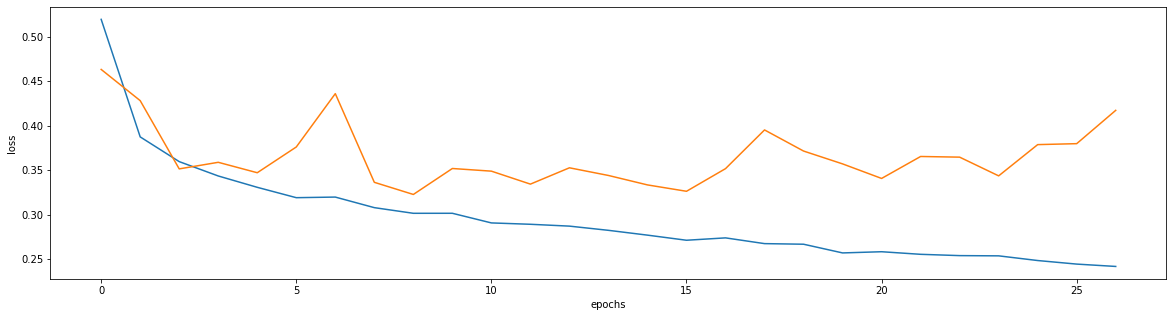

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [ ]:
y_pred= tcn_model.predict(test_signal)
predict=[int(x+0.5) for x in y_pred]
# vot.append(np.array(predict_a))
conf_mat=confusion_matrix(test_bclass,predict)
print(conf_mat)

[[1000  239]
 [  80  884]]


In [ ]:
accuracy_score(test_bclass,predict)

0.8551974580118021

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_bclass, y_pred)
metrics.auc(fpr, tpr)

0.9372758281173079

In [ ]:
def tcn_model(kernel_size = 3, activation='relu'):
    
    inp = Input( shape=(1000,12))
    
    x = SpatialDropout1D(0.1)(inp)
    
    x = TCN(128,dilations = [1, 2, 4, 8, 16, 32, 64], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(64,dilations = [1, 2, 4, 8, 16, 32, 64], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'])
    
    return model

In [ ]:
tcn_model = tcn_model ()

In [ ]:
tcn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 1000, 12)    0           ['input_1[0][0]']                
 out1D)                                                                                           
                                                                                                  
 tcn1 (TCN)                     (None, 1000, 128)    647040      ['spatial_dropout1d[0][0]']      
                                                                                                  
 tcn2 (TCN)                     (None, 1000, 64)     193472      ['tcn1[0][0]']               

In [ ]:
history = tcn_model.fit(signal,target, epochs=1000, callbacks=[reduce_lr], validation_data=(v_signal,v_target))

Epoch 1/1000
546/546 [==============================] - 93s 141ms/step - loss: 0.8447 - accuracy: 0.6416 - val_loss: 0.5094 - val_accuracy: 0.7839 - lr: 0.0010
Epoch 2/1000
546/546 [==============================] - 76s 139ms/step - loss: 0.4833 - accuracy: 0.7786 - val_loss: 0.4496 - val_accuracy: 0.7994 - lr: 0.0010
Epoch 3/1000
546/546 [==============================] - 76s 139ms/step - loss: 0.4290 - accuracy: 0.8192 - val_loss: 0.3935 - val_accuracy: 0.8322 - lr: 0.0010
Epoch 4/1000
546/546 [==============================] - 76s 139ms/step - loss: 0.4031 - accuracy: 0.8300 - val_loss: 0.3684 - val_accuracy: 0.8486 - lr: 0.0010
Epoch 5/1000
546/546 [==============================] - 76s 140ms/step - loss: 0.3687 - accuracy: 0.8397 - val_loss: 0.3493 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 6/1000
546/546 [==============================] - 76s 140ms/step - loss: 0.3401 - accuracy: 0.8537 - val_loss: 0.3424 - val_accuracy: 0.8509 - lr: 0.0010
Epoch 7/1000
546/546 [==================

KeyboardInterrupt: ignored

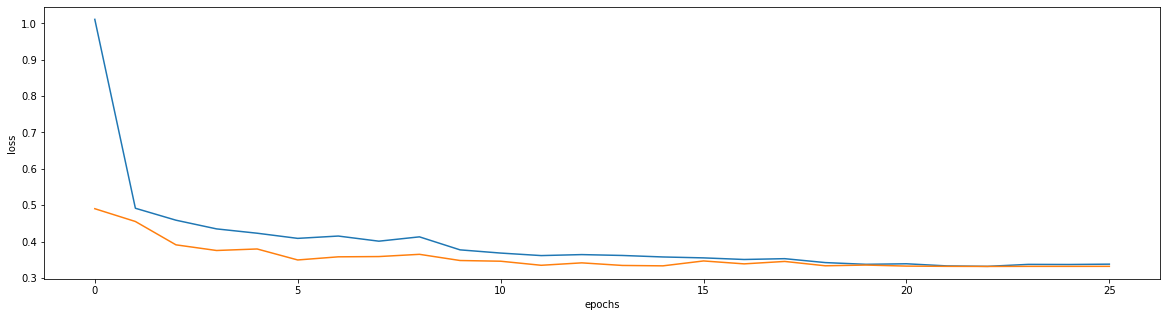

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [ ]:
y_pred= tcn_model.predict(test_signal)
predict=[int(x+0.5) for x in y_pred]
# vot.append(np.array(predict_a))
conf_mat=confusion_matrix(test_bclass,predict)
print(conf_mat)

[[1016  223]
 [ 120  844]]


In [ ]:
accuracy_score(test_bclass,predict)

0.8443032228778938

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_bclass, predict)
metrics.auc(fpr, tpr)

0.8477674071246052